# Implement image blending

We will start by importing libraries and defining a couple of functions for displaying images using matplotlib.

In [80]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]

def showResult(title, img):
    # Colour images in OpenCV are given in BGR, but matplotlib expects RGB.
    # We therefore need to convert the OpenCV images.
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()

def showResultsSideBySide(title1, img1, title2, img2):
    # Display the original and the transformed image
    axes = plt.subplots(1, 2)[1]
    ax1, ax2 = axes
    ax1.set_title(title1)
    ax2.set_title(title2)
    ax1.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    ax2.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    plt.show()

## 1. Load and convert the source images
Now let's do some image processing!

First, we need to read the two images we want to blend.

  <table cellspacing="0" cellpadding="0"><tr>
    <td> <img src="img/thumb_lion.png" alt="Lion" style="width: 200px;"/> </td>
    <td> <img src="img/thumb_tiger.png" alt="Tiger" style="width: 200px;"/> </td>
    <td> <img src="img/thumb_white_tiger.png" alt="White tiger" style="width: 200px;"/> </td>
  </tr></table>

- Read two images (choose two of the images given in the `data` directory)
  - Hint: [cv::imread(...)](https://docs.opencv.org/4.0.1/d4/da8/group__imgcodecs.html#ga288b8b3da0892bd651fce07b3bbd3a56)

- Convert the images to `float32` and scale the pixel values so that they will lie in the interval [0, 1]
  - Hint: [numpy.float32](https://numpy.org/doc/stable/reference/arrays.scalars.html?#numpy.float32)

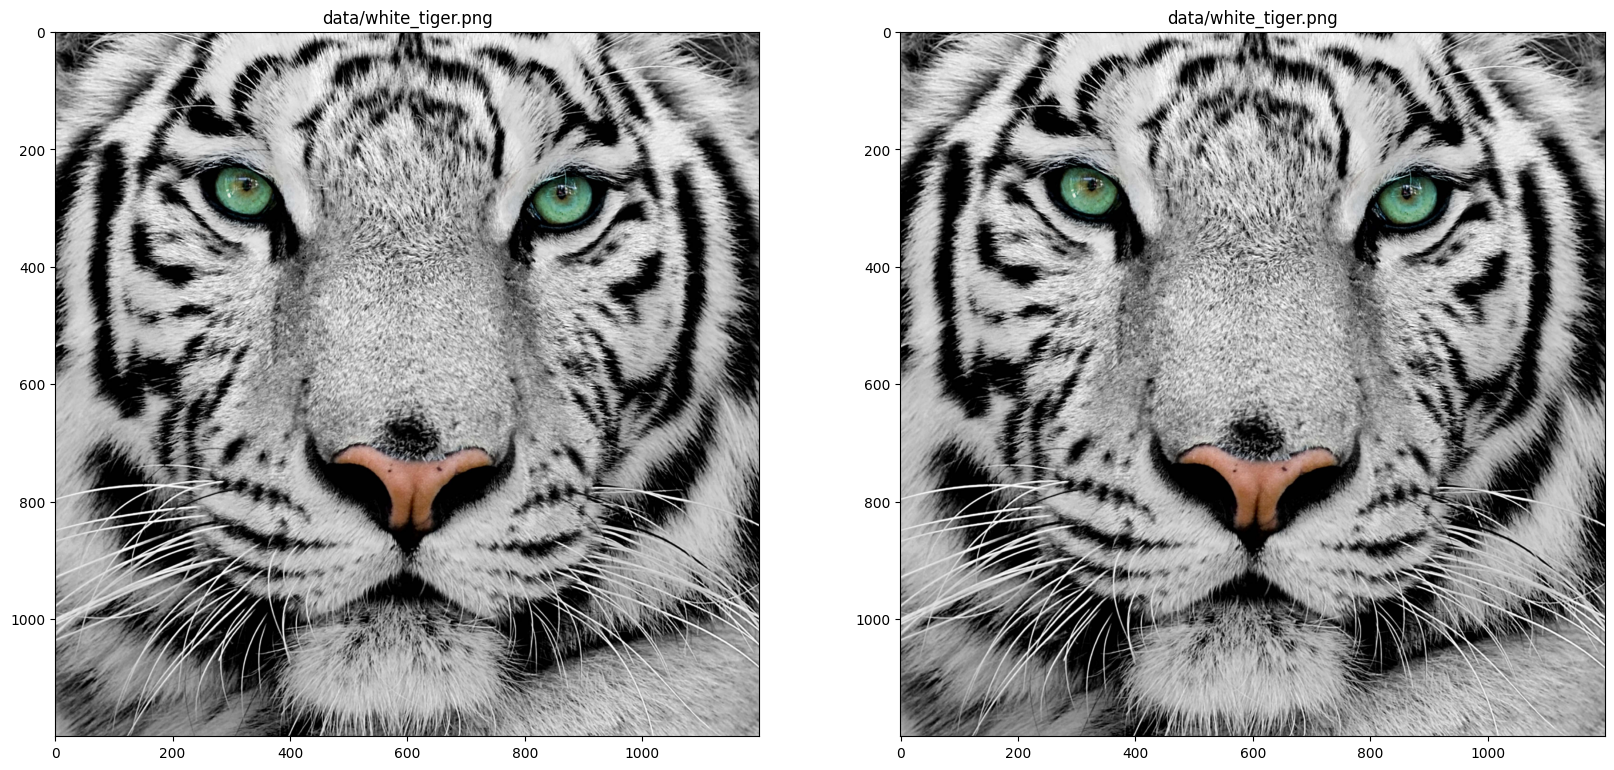

In [92]:
# Load the images.
img_01_fname = "data/white_tiger.png"
img_01 = np.float32(cv2.imread(img_01_fname)) / 255

img_02_fname = "data/white_tiger.png"
img_02 = np.float32(cv2.imread(img_02_fname)) / 255

# Show the loaded images.
showResultsSideBySide(img_01_fname, img_01, img_02_fname, img_02)

## 2. Create an image with weights for blending
Now we need to define how the two images should be blended together.
We will do this by constructing a weight image with weights $w(u, v) \in [0, 1].$

A weight of 1 means that the blended pixel will be equal to the corresponding pixel in image 1, while a weight of 0.5 means that the resulting pixel is an equally large mix of both images.

### a) Create the weight image:
  - The size is equal to the size of the input images
  - It should have 3 channels given in 32-bit floating point
  - The left half of the image should be black (pixel value 0.0 in all channels)
  - The right half of the image should be white (pixel value 1.0 in all channels)

### b) Make a ramp (a smooth gradient) in the transition between black and white
   - Hint: [cv::blur](https://docs.opencv.org/4.5.5/d4/d86/group__imgproc__filter.html#ga8c45db9afe636703801b0b2e440fce37)

   ![Weight image with ramp](img/gradient.png)

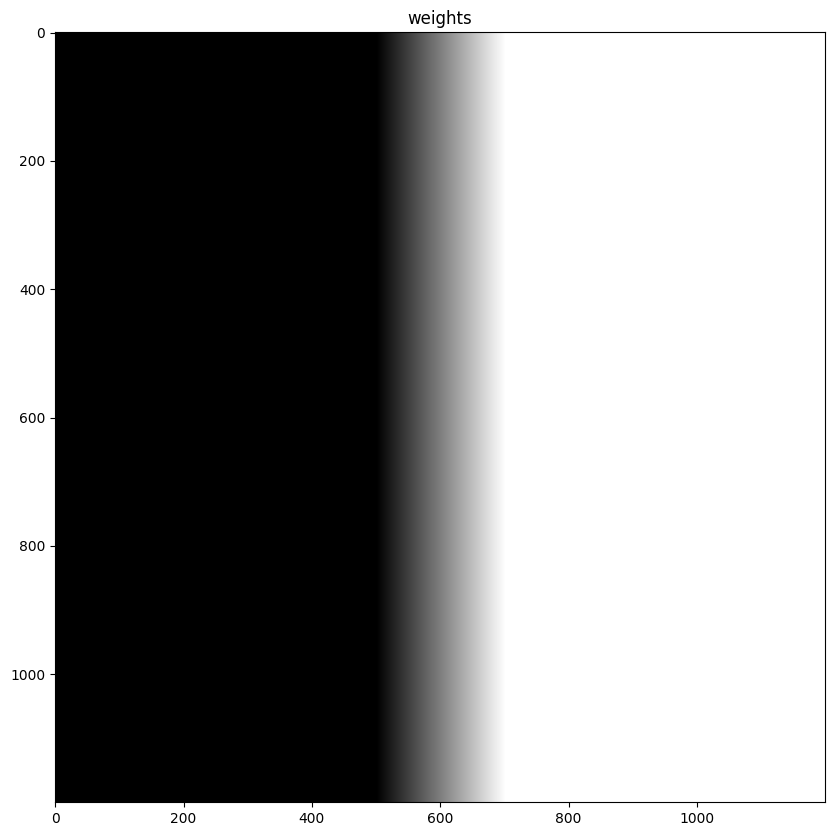

In [90]:
# Construct a half black, half white image.
left_part = np.zeros((1200, 600, 3), dtype=np.float32)
right_part = np.ones((1200, 600, 3), dtype=np.float32)
weights = np.hstack((left_part, right_part))

# Create a ramp between the two halves.
ramp_width = 200
weights = cv2.blur(weights, (ramp_width, ramp_width))


# Visualise the weights.
showResult("weights", weights)

## 3. Simple linear blending
The next step is to implement functionality for simple linear blending, where the two images are mixed according to the weight image.

### a) Implement linear blending of two images using the weights
- $res = w  \cdot img_1 + (1-w) \cdot img_2$
- Tip: You can solve this step using only image operations, without writing any loops.

### b) Run the code and check that the result looks reasonable
- Try changing the ramp size `ramp_width`. What happens?
- Try making the blend as smooth and visually pleasing as possible.

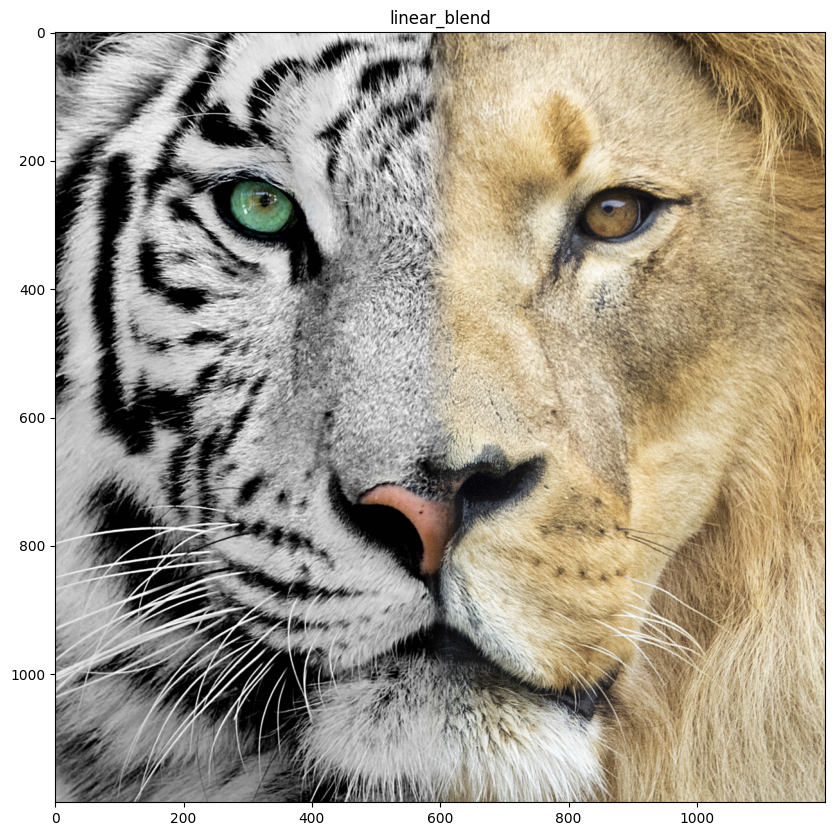

In [83]:
def linearBlending(img1, img2, mask):
    res = img1 * mask + img2 * (1.0-mask)
    return res

# Test linear blending.
linear_blend = linearBlending(img_01, img_02, weights)
showResult('linear_blend', linear_blend)

## 4. Laplace blending
To demonstrate the difference between simple linear blending, and scale-aware blending, we will now implement and test Laplace blending.
We will even get to play around with scale pyramids!

Recall from the lecture that Laplace blending performs linear blending at different stages in the laplacian pyramid for an image (at different scales):

![Laplace blending](img/thumb_fig_laplace.png)

First we convert the image to a laplacian pyramid, then we perform the linear blending, and finally we reconstruct the blended laplacian into the resulting blended image.

### a) Construct a Gaussian pyramid

![Gaussian pyramid](img/thumb_pyr_gauss.png)

- Hint: Use [cv::pyrDown()](https://docs.opencv.org/4.5.5/d4/d86/group__imgproc__filter.html#gaf9bba239dfca11654cb7f50f889fc2ff)


In [84]:
def constructGaussianPyramid(img):
    # Construct the pyramid starting with the original image.
    pyr = [img]

    # Add new downscaled images to the pyramid
    # until image width is <= 16 pixels
    while pyr[-1].shape[1] > 16:
        pyr.append(cv2.pyrDown(pyr[-1]))

    return pyr

### b) Construct a Laplacian pyramid

![Laplacian pyramid](img/thumb_pyr_laplace.png)

- Hint: Use [cv::pyrUp()](https://docs.opencv.org/4.5.5/d4/d86/group__imgproc__filter.html#gada75b59bdaaca411ed6fee10085eb784)


In [85]:
def constructLaplacianPyramid(img):
    # TODO: Use constructGaussianPyramid() to construct a laplacian pyramid.
    pyr = constructGaussianPyramid(img)
    for k in range(len(pyr)-1):
        pyr[k] = pyr[k] - cv2.pyrUp(pyr[k+1], dstsize=pyr[k].shape[0:2])

    return pyr

### c) Implement function for collapsing the Laplacian pyramid
![Collapsing the Laplacian pyramid](img/thumb_pyr_collapse.png)

- Hint: Use [cv::pyrUp()](https://docs.opencv.org/4.5.5/d4/d86/group__imgproc__filter.html#gada75b59bdaaca411ed6fee10085eb784)


In [86]:
def collapsePyramid(pyr):
    # TODO: Collapse the pyramid.
    for i in range(len(pyr)-2, -1, -1):
        pyr[i] = pyr[i] + cv2.pyrUp(pyr[i+1], dstsize=pyr[i].shape[0:2])

    return pyr[0]

### d) Implement Laplacian blending
- Construct a Gaussian pyramid for the weights.
- Construct Laplacian pyramids for the images.
- Blend the images using `linearBlending()` on each pyramid level.
- Reconstruct the blended image by collapsing the blended pyramid.

In [87]:
def laplaceBlending(img1, img2, mask):
    # Construct a gaussian pyramid of the mask image.
    pyr_mask = constructGaussianPyramid(mask)

    # Construct a laplacian pyramid of each of the images.
    pyr_img1 = constructLaplacianPyramid(img1)
    pyr_img2 = constructLaplacianPyramid(img2)

    # Blend the laplacian pyramids according to the corresponding weight pyramid.
    pyr_blend = []
    for img1_lvl, img2_lvl, mask_lvl in zip(pyr_img1, pyr_img2, pyr_mask):
        # TODO: Blend the images using linearBlending() on each pyramid level (remove the "pass")
        pyr_blend.append(linearBlending(img1_lvl, img2_lvl, mask_lvl))

    # Collapse the blended Laplacian pyramid.
    return collapsePyramid(pyr_blend)

### e) Check that the results look reasonable
- Test Laplace blending
- Compare the results with linear blending.
- What happens when you reduce the ramp size down to a very steep gradient?

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4901161e-07..1.0].


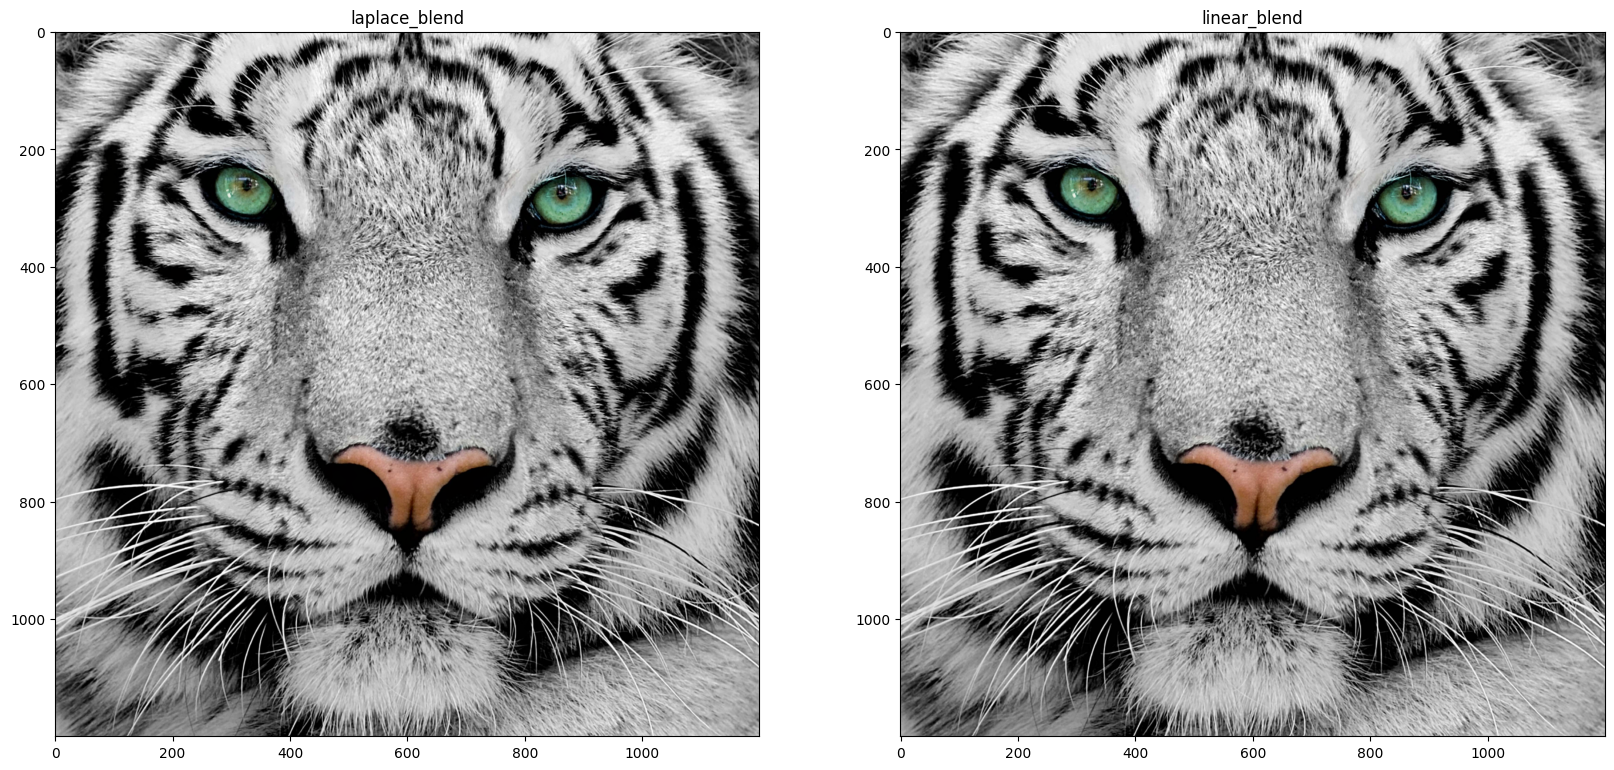

In [93]:
# Test Laplace blending.
lap_blend = laplaceBlending(img_01, img_02, weights)
linear_blend = linearBlending(img_01, img_02, weights)
showResultsSideBySide('laplace_blend', lap_blend, 'linear_blend', linear_blend)

### f) Experiments
Try other images
 - Capture images using the camera
 - Download images from the internet

Try other weight masks
 - Circles
 - Other shapes